**Оценка возможности прогнозирования ДТП**

***Источник данных:*** данные предоставлены заказчиком.

***Характер данных:*** информация о происшествиях, описание участников происшествия, описание автомобиля.

***Цель заказчика:*** создание системы, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

***Задача исследования:*** понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Идея решения задачи от заказчика:**

1. Создать модель предсказания ДТП (целевое значение — `at_fault` (виновник) в таблице `parties`).
2. Для модели выбрать тип виновника — только машина (`car`).
3. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа `SCRATCH` (царапина).
4. Для моделирования ограничиться данными за 2012 год — они самые свежие.
5. Обязательное условие — учесть фактор возраста автомобиля.
6. На основе модели исследовать основные факторы ДТП.
7. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    * Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    * Какие ещё факторы нужно учесть?
    * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
8. Предложить идеи создания такой системы. 

Краткое описание таблиц:  
        
 - `collisions` — общая информация о ДТП. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

 - `parties` — информация об участниках ДТП. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.  

 - `vehicles` — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

### Импорт библиотек

!pip install -U scikit-learn
!pip install ydata-profiling
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install shap

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
import shap

from sqlalchemy import create_engine
#from ydata_profiling import ProfileReport

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
SEED = 42

## Подключитесь к базе. Загрузите таблицы sql

Сохранение параметров подключения к базе данных:

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


Создание строки соединения с базой данных:

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

Подключение к базе данных:

In [5]:
engine = create_engine(connection_string)

In [6]:
# Создадим пробный запрос:
query = '''
SELECT COUNT(DISTINCT id) AS count_parties
  FROM parties
 WHERE at_fault = 1;
'''
df = pd.read_sql_query(query, con=engine)
df.head()

,count_parties
0,1288127


In [7]:
# sql запрос
query = '''
SELECT pg_size_pretty(pg_database_size(current_database()));
'''
df = pd.read_sql_query(query, con=engine)
df

,pg_size_pretty
0,790 MB


***Вывод:***
- подключились к серверу
- вывели колличество всех уникальных виновников ДТП.
- размер базы данных 790 MB

## Проведите первичное исследование таблиц

In [8]:
query = '''
SELECT table_name, table_schema, table_type
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
'''
s_q_l = pd.read_sql_query(query, con=engine)
s_q_l

,table_name,table_schema,table_type
0,pg_type,pg_catalog,BASE TABLE
1,pg_foreign_table,pg_catalog,BASE TABLE
2,pg_amop,pg_catalog,BASE TABLE
3,pg_amproc,pg_catalog,BASE TABLE
4,pg_language,pg_catalog,BASE TABLE
...,...,...,...
59,pg_inherits,pg_catalog,BASE TABLE
60,collisions,public,BASE TABLE
61,case_ids,public,BASE TABLE
62,parties,public,BASE TABLE


### Таблица `case_ids`:

In [9]:
# sql запрос
query = '''

SELECT *
FROM case_ids
LIMIT 5

'''

case_id_df = pd.read_sql_query(query, con=engine) 
case_id_df

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Таблица содержит уникальный case_id, второй столбец отличается от представленного в документации и скорее всего обозначает год создания базы данных.

In [10]:
# проверим уникальность значений столбца case_id
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM case_ids;
'''

case_id_df_ = pd.read_sql_query(query, con=engine)
case_id_df_ 

,total_rows,total_case_id
0,1400000,1400000


Значения уникальны.

### Таблица `vehicles`:

In [11]:
# sql запрос
query = '''

SELECT *
FROM vehicles
LIMIT 10

'''

vehicles_df = pd.read_sql_query(query, con=engine) 
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Таблица содержит данные об автомобилях, участвовавших в ДТП.

In [12]:
# sql запрос
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM vehicles;
'''

vehicles_df_ = pd.read_sql_query(query, con=engine) 
vehicles_df_

,total_rows,total_case_id
0,1021234,792642


Значения не уникальны, т.к. одному case_id может быть сопоставлено несколько id из таблицы

### Таблица `collisions`:

In [13]:
# sql запрос
query = '''

SELECT *
FROM collisions
LIMIT 5
'''

collisions_df = pd.read_sql_query(query, con=engine) 
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица содержит информацию о происшествия, содержимое столбцов также не использует буквенные сокращения.

In [14]:
# sql запрос
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM collisions;
'''

collisions_df_ = pd.read_sql_query(query, con=engine) 
collisions_df_

,total_rows,total_case_id
0,1400000,1400000


Значения уникальны.

### Таблица `parties`:

In [15]:
# sql запрос
query = '''

SELECT *
FROM parties
LIMIT 5

'''

parties_df = pd.read_sql_query(query, con=engine) 
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Таблица содержит описание участников происшествия, названия столбцов соотвествуют описанию, но столбцы содержат полное название вместо буквенного сокращения как указано в описании к данным.

In [16]:
# sql запрос
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM parties;
'''

parties_df_ = pd.read_sql_query(query, con=engine) 
parties_df_

,total_rows,total_case_id
0,2752408,1400000


Значения не уникальны, т.к. одному case_id может быть сопоставлено несколько id из таблицы

***Вывод:***
- Имеется общий ключ для связи таблиц - `case_id`.
- Таблицы и названия столбцов соответствуют описанию. Столбцы таблиц `parties` и `collisions` содержат полное название вместо буквенного сокращения как указано в описании к данным.
- В таблице `vehicles` кол-во уникальных `case_id` меньше.

##  Проведите статистический анализ факторов ДТП

Проверка доступных временных промежутков базы данных:

In [17]:
# sql запрос
query = '''
SELECT min(collision_date),
       max(collision_date)
FROM collisions
;
'''

date_df = pd.read_sql_query(query, con=engine)
date_df

,min,max
0,2009-01-01,2020-07-26


Таблица `collisions` содержит информацию о проишествиях с 01-01-2009 по 26-07-2020

### Месяцы с наибольшим кол-вом аварий

***1.Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).***
 - Создайте sql-запрос;
 - Постройте график;
 - Сделайте вывод.


In [18]:
# sql запрос
query = '''
SELECT CAST(EXTRACT(month FROM collision_date) AS INTEGER) AS month_num,
       TO_CHAR(collision_date, 'Month') AS month,
       COUNT(*) AS collision_count
FROM collisions
GROUP BY month, month_num
ORDER BY month_num;
'''

month_df = pd.read_sql_query(query, con=engine)
month_df

,month_num,month,collision_count
0,1,January,132044
1,2,February,128858
2,3,March,139581
3,4,April,130180
4,5,May,130316
5,6,June,102594
6,7,July,102227
7,8,August,104089
8,9,September,105159
9,10,October,112237


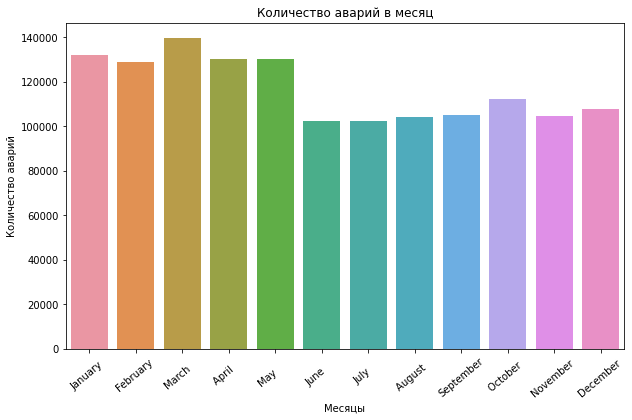

In [19]:
# Построим график:
plt.figure(figsize=[10,6])

sns.barplot(data = month_df, x='month', y='collision_count')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

* Наибольшее количество ДТП наблюдается в период с января по май, дальше идет резкое снижение, пик приходится на март. Такой всплеск можно обьяснить неблагоприятными погодными условиями и состоянием дорог в зимне-весенний период, либо же неполнотой данных за период с июня по декабрь.

### Постановка задач для рабочей группы

Поскольку перед исследованием стоит задача установить, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов, необходимо рассмотреть соотношение факторов во всех предоставленных таблицах (`collisions`, `Parties`, `Vehicles`), которые также могли привести к возникновению происшествий.  

 1. Найти самые частые причины ДТП c участником происшествия 'car' (`collisions`, `parties`).  
 
 
 2. Определить возраст автомобилей, которые чаще попадают в ДТП (`collisions`, `vehicles`).  
 
 
 3. Определить тип трансмиссии, при котором происходит наибольшее количество ДТП (`collisions`, `vehicles`).  
 
 
 4. Определить тип кузова, при котором происходит наибольшее количество ДТП (`collisions`, `vehicles`).  
 
 
 5. Определить: при наличии или отсутствии телефона - происходит наибольшее количество ДТП (`collisions`, `parties`).   
 
 
 6. Выявить пять округов, в которых наиболее часто виновниками аварии являются пьяные водители (число виновников ДТП) в ночное время (с 23:00 до 05:00), а также средний возраст автомобилей по этим округам (`collisions`, `vehicles`, `parties`)

Порядок решения поставленных перед анализом данных задач будет выглядеть следующим образом:

1. Формулирование задачи анализа.
2. Создание sql-запроса.
3. Сохранение результата sql-запроса в таблицу
3. Построение графика или таблицы, наглядно демонстрирующего зависимости в данных.
4. Формирование вывода на основе поведения данных.

***Задача 1:***  Найти самые частые причины ДТП c участником происшествия 'car'

In [20]:
# sql запрос
query = '''
select distinct primary_collision_factor,
       count(primary_collision_factor) count_collision_factor
from collisions as c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_type = 'car' 
        AND primary_collision_factor != 'unknown' 
group by primary_collision_factor
order by count_collision_factor desc
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,2351857
1,other than driver,35937
2,other improper driving,11126
3,fell asleep,139


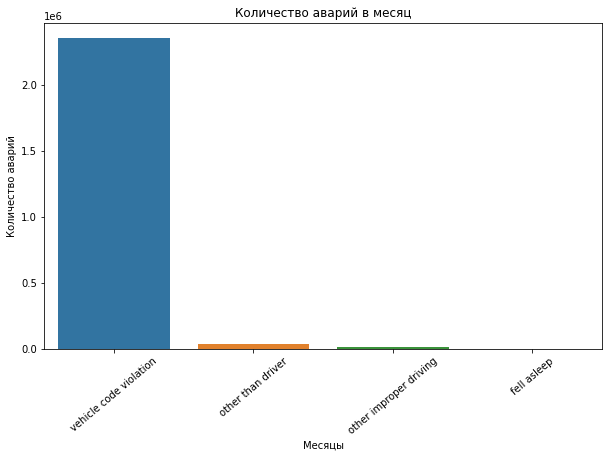

In [21]:
# Построим график:
plt.figure(figsize=[10,6])
sns.barplot(data = collisions_reasons, x='primary_collision_factor', y='count_collision_factor')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

* Самой частой причиной аварий является нарушение ПДД

***Задача 2:*** Определить возраст автомобилей, которые чаще попадают в ДТП

In [22]:
# sql запрос
query = '''
SELECT vehicle_age,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Vehicles AS v ON c.case_id = v.case_id
GROUP BY vehicle_age
ORDER BY total_collisions desc
Limit 10;
'''

vehicle_age_collisions = pd.read_sql_query(query, con=engine)
vehicle_age_collisions

,vehicle_age,total_collisions
0,3,178550
1,4,125472
2,2,106530
3,5,105035
4,6,84362
5,7,84282
6,8,77070
7,9,58255
8,1,41307
9,0,40262


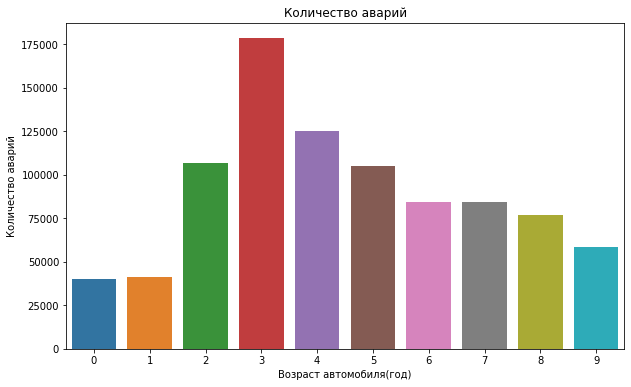

In [23]:
# Построим график:
plt.figure(figsize=[10,6])
sns.barplot(data = vehicle_age_collisions, x='vehicle_age', y='total_collisions')
plt.title('Количество аварий')
plt.xlabel('Возраст автомобиля(год)')
plt.ylabel('Количество аварий')
plt.show()

* Большая часть ДТП произошла с автомобилями в возрасте 3 лет

## Создайте модель для оценки водительского риска

### Выявление признаков и выгрузка данных

Отберем факторы, которые могут влиять на вероятность стать виновником ДТП

Таблица vehicles:

 - `vehicle_transmission` -  авто с МКПП может быть сложнее для  неопытных водителей, использующих каршеринг.
 - `vehicle_age` - возраст автомобиля (амортизация ТС может оказывать влияние на передвижение и маневренность).
 
Таблица parties:
 - `at_fault` - целевой признак;
 - `cellphone_in_use` - использование телефона снижает внимательность;
 - `party_sobriety` - трезвость водителя;
 
Таблица collisions:

 - `weather_1` - погода;
 - `intersection` - чаще всего, по статистике, ДТП происходят именно на перекрестках;
 - `pcf_violation_category`- основная причина аварии, выявление причины позволит предотвращать аварии в будущем;
 - `motor_vehicle_involved_with` - дополнительные участники ДТП, выявление наиболее частых участников позволит уменьшить число дтп;
 - `road_surface` - состояние поверхности дороги - гололед, мокрая/скользкая/сухая дорога;
 - `control_device` - наличие контролирующего утройства - неизвестный фактор, который может оказать влияние
 - `lighting` - освещенность дороги.
 
 
С помощью запроса выгрузим необходимые данные в таблицу. По условию задачи, нужны только данные за 2012 год, где участник аварии - машина и с повреждениями больше чем царапина. 

In [24]:
# sql запрос
query = '''

SELECT DISTINCT c.case_id,
       weather_1,
       pcf_violation_category,
       motor_vehicle_involved_with,
       road_surface,
       control_device,
       lighting,
       vehicle_transmission,
       vehicle_age,
       cellphone_in_use, 
       party_sobriety,
       at_fault
FROM collisions c
Inner JOIN parties p ON c.case_id = p.case_id 
Inner JOIN vehicles v ON c.case_id = v.case_id 
WHERE (extract(YEAR FROM cast(collision_date AS date))::int = 2012
  AND party_type = 'car'
  AND collision_damage != 'scratch')


'''
# Сохраняем в датафрейм
df_dtp = pd.read_sql_query(query, con=engine) 

df_dtp.head(10)

,case_id,weather_1,pcf_violation_category,motor_vehicle_involved_with,road_surface,control_device,lighting,vehicle_transmission,vehicle_age,cellphone_in_use,party_sobriety,at_fault
0,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,2.0,0.0,had not been drinking,0
1,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,2.0,0.0,had not been drinking,1
2,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,5.0,0.0,had not been drinking,0
3,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,5.0,0.0,had not been drinking,1
4,5269486,clear,unknown,other motor vehicle,dry,functioning,daylight,auto,1.0,0.0,had not been drinking,0
5,5319820,clear,improper turning,other motor vehicle,dry,functioning,dark with street lights,auto,4.0,0.0,had not been drinking,0
6,5319820,clear,improper turning,other motor vehicle,dry,functioning,dark with street lights,auto,4.0,0.0,had not been drinking,1
7,5329109,clear,other hazardous violation,other motor vehicle,dry,functioning,daylight,auto,6.0,0.0,had not been drinking,0
8,5329109,clear,other hazardous violation,other motor vehicle,dry,functioning,daylight,auto,6.0,0.0,had not been drinking,1
9,5403028,clear,pedestrian violation,other object,dry,functioning,dark with street lights,auto,2.0,0.0,had not been drinking,0


### Предподготовка  и анализ данных

Названия столбцов приведем к стандарту PEP8.

In [25]:
df_dtp.rename(columns={'weather_1':'weather'}, inplace=True)

In [26]:
df_dtp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103047 entries, 0 to 103046
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      103047 non-null  object 
 1   weather                      102737 non-null  object 
 2   pcf_violation_category       101565 non-null  object 
 3   motor_vehicle_involved_with  102769 non-null  object 
 4   road_surface                 102417 non-null  object 
 5   control_device               102646 non-null  object 
 6   lighting                     102763 non-null  object 
 7   vehicle_transmission         101389 non-null  object 
 8   vehicle_age                  100059 non-null  float64
 9   cellphone_in_use             93068 non-null   float64
 10  party_sobriety               101447 non-null  object 
 11  at_fault                     103047 non-null  int64  
dtypes: float64(2), int64(1), object(9)
memory usage: 9.4+ MB


In [27]:
#profile = ProfileReport(df_dtp, title="Profiling Report").to_notebook_iframe()

In [28]:
df_dtp.isna().sum()/len(df_dtp)

case_id                        0.000000
weather                        0.003008
pcf_violation_category         0.014382
motor_vehicle_involved_with    0.002698
road_surface                   0.006114
control_device                 0.003891
lighting                       0.002756
vehicle_transmission           0.016090
vehicle_age                    0.028996
cellphone_in_use               0.096839
party_sobriety                 0.015527
at_fault                       0.000000
dtype: float64

Что необходимо исправить:

   * Необходимо убрать экстремальные значения из столбца `vehicle_age`.
   * В столбце `weather` есть категория `other`, перенесём в нее пропущенные значения.
   * В столбце `pcf_violation_category` есть категория `unknown`, перенесём в нее пропущенные значения.
   * В столбце `motor_vehicle_involved_with` есть категория `other object`, перенесём в нее пропущенные значения.
   * В столбце `road_surface` запишем пропуски в категорию `unknown`.
   * В столбце `control_device` есть категория `none`, перенесём в нее пропущенные значения.
   * В столбце `lighting` запишем пропуски в категорию `unknown`.
   * В столбце `party_sobriety` есть категория `impairment unknown`, перенесём в нее пропущенные значения.
   * В столбце `vehicle_transmission`, запишем пропуски в категорию `manual`.
   * В столбец `cellphone_in_use` также добавим категорию `unknown`.
   * Столбец `vehicle_age` заполним Imputer - ммедианнвм значением.   

In [29]:
df_dtp.drop(index=df_dtp[df_dtp['vehicle_age'] > df_dtp['vehicle_age'].quantile(0.99)].index, inplace=True)

df_dtp['weather'] = df_dtp['weather'].fillna('other')

df_dtp['pcf_violation_category'] = df_dtp['pcf_violation_category'].fillna('unknown')

df_dtp['motor_vehicle_involved_with'] = df_dtp['motor_vehicle_involved_with'].fillna('other object')

df_dtp['road_surface'] = df_dtp['road_surface'].fillna('unknown')

df_dtp['control_device'] = df_dtp['control_device'].fillna('none')

df_dtp['lighting'] = df_dtp['lighting'].fillna('unknown')

df_dtp['party_sobriety'] = df_dtp['party_sobriety'].fillna('impairment unknown')

df_dtp['vehicle_transmission'] = df_dtp['vehicle_transmission'].fillna('unknown')

df_dtp['cellphone_in_use'] = df_dtp['cellphone_in_use'].fillna('unknown')
df_dtp['cellphone_in_use'] = df_dtp['cellphone_in_use'].replace(0, 'no')
df_dtp['cellphone_in_use'] = df_dtp['cellphone_in_use'].replace(1, 'yes')

#df_dtp['intersection'] = df_dtp['intersection'].replace(0, 'no')
#df_dtp['intersection'] = df_dtp['intersection'].replace(1, 'yes')

imputer = SimpleImputer(strategy='median')
df_dtp[['vehicle_age']] = imputer.fit_transform(df_dtp[['vehicle_age']])

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [30]:
df_dtp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102397 entries, 0 to 103046
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      102397 non-null  object 
 1   weather                      102397 non-null  object 
 2   pcf_violation_category       102397 non-null  object 
 3   motor_vehicle_involved_with  102397 non-null  object 
 4   road_surface                 102397 non-null  object 
 5   control_device               102397 non-null  object 
 6   lighting                     102397 non-null  object 
 7   vehicle_transmission         102397 non-null  object 
 8   vehicle_age                  102397 non-null  float64
 9   cellphone_in_use             102397 non-null  object 
 10  party_sobriety               102397 non-null  object 
 11  at_fault                     102397 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 10.2+ MB

Пропусков нет.

Проверим на наличие полных дубликатов:

In [31]:
df.duplicated().sum()

0

Посмотрим уникальные значения `lighting`

In [32]:
df_dtp['lighting'].unique() 

array(['daylight', 'dark with street lights', 'dusk or dawn',
       'dark with no street lights',
       'dark with street lights not functioning', 'unknown'], dtype=object)

Избавимся от пробелов в названиях и от слишком большого кол-ва категорий - присвоим значение dark всем категориям, обозначающим неосвещенную улицу.

In [33]:
# Функция, заменяющая все пробелы на подчеркивания
def fix_value(cell):
     cell = cell.replace(' ', '_')  
     return cell 

In [34]:
df_dtp['lighting'] = df_dtp['lighting'].apply(lambda x: 'dark' if 'dark' in x else x)
df_dtp['lighting'] = df_dtp['lighting'].apply(fix_value)


df_dtp['lighting'].unique() 

array(['daylight', 'dark', 'dusk_or_dawn', 'unknown'], dtype=object)

То же самое сделаем с признаком `party_sobriety`, оставив только факт, был участник в состоянии опьянения или нет:

In [35]:
df_dtp['party_sobriety'].unique()

array(['had not been drinking', 'impairment unknown',
       'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence', 'not applicable'],
      dtype=object)

In [36]:
df_dtp['party_sobriety'] = df_dtp['party_sobriety'].apply(lambda x: 'sober' if 'had not' in x else x)
df_dtp['party_sobriety'] = df_dtp['party_sobriety'].apply(lambda x: 'drunk' if 'had been' in x else x)
df_dtp['party_sobriety'] = df_dtp['party_sobriety'].apply(lambda x: 'drunk' if 'impairment' in x else x)

df_dtp['party_sobriety'] = df_dtp['party_sobriety'].apply(fix_value)

In [37]:
df_dtp['party_sobriety'].unique() 

array(['sober', 'drunk', 'not_applicable'], dtype=object)

Рассмотрим категории нарушений. Здесь можно обьединить нарушения правил пешеходами в одну группу, тк задача - рассмотреть причины только автомобильных аварий. Также можно объединить в одну категорию технические неисправности.

In [38]:
df_dtp['pcf_violation_category'].unique() 

array(['automobile right of way', 'speeding', 'unknown',
       'improper turning', 'other hazardous violation',
       'pedestrian violation', 'other improper driving', 'dui',
       'pedestrian right of way', 'traffic signals and signs',
       'other than driver (or pedestrian)', 'wrong side of road',
       'improper passing', 'other equipment', 'unsafe lane change',
       'hazardous parking', 'following too closely',
       'unsafe starting or backing', 'lights', 'impeding traffic',
       'brakes', 'fell asleep'], dtype=object)

In [39]:
# неисправности трнспортного средства:
df_dtp['pcf_violation_category'] = df_dtp['pcf_violation_category'].apply(lambda x: 'equipment_fault' 
                                                                          if x == 'brakes' 
                                                                          or x == 'other equipment'
                                                                          or x == 'lights' else x)
# нарушения правил пешеходами
df_dtp['pcf_violation_category'] = df_dtp['pcf_violation_category'].apply(lambda x: 'pedestrian_involved' 
                                                                          if x == 'automobile right of way'
                                                                          or x == 'pedestrian violation' 
                                                                          or x == 'dui' 
                                                                          or x == 'other than driver (or pedestrian)' 
                                                                          or x == 'improper passing' else x)

df_dtp['pcf_violation_category'] = df_dtp['pcf_violation_category'].apply(fix_value)

df_dtp['pcf_violation_category'].unique() 

array(['pedestrian_involved', 'speeding', 'unknown', 'improper_turning',
       'other_hazardous_violation', 'other_improper_driving',
       'pedestrian_right_of_way', 'traffic_signals_and_signs',
       'wrong_side_of_road', 'equipment_fault', 'unsafe_lane_change',
       'hazardous_parking', 'following_too_closely',
       'unsafe_starting_or_backing', 'impeding_traffic', 'fell_asleep'],
      dtype=object)

In [40]:
# Столкновение с другими участниками ДТП:
df_dtp['motor_vehicle_involved_with'].unique() 

array(['other motor vehicle', 'other object', 'fixed object',
       'non-collision', 'bicycle', 'parked motor vehicle', 'train',
       'animal', 'motor vehicle on other roadway'], dtype=object)

In [41]:
# столкновение с другим движущимся ТС:
df_dtp['motor_vehicle_involved_with'] = df_dtp['motor_vehicle_involved_with'].apply(lambda x: 'other_vehicle' 
                                                                                    if x == 'other motor vehicle' 
                                                                                    or x == 'motor vehicle on other roadway'
                                                                                    else x)
# столкновение с неподвижным объектом:
df_dtp['motor_vehicle_involved_with'] = df_dtp['motor_vehicle_involved_with'].apply(lambda x: 'fixed object' 
                                                                                    if x == 'parked motor vehicle' 
                                                                                    else x)

df_dtp['motor_vehicle_involved_with'] = df_dtp['motor_vehicle_involved_with'].apply(fix_value)

df_dtp['motor_vehicle_involved_with'].unique()

array(['other_vehicle', 'other_object', 'fixed_object', 'non-collision',
       'bicycle', 'train', 'animal'], dtype=object)

Применим downcast, чтобу уменьшить потребление памяти и ускорить работу.

In [42]:
df_dtp['at_fault'] = pd.to_numeric(df_dtp['at_fault'], downcast='integer')
df_dtp['vehicle_age'] = pd.to_numeric(df_dtp['vehicle_age'], downcast='integer')

In [43]:
df_dtp.loc[:, df_dtp.dtypes == 'object'] =\
    df_dtp.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

In [44]:
# удаляем `case_id` (уникальный номер зарегистрированного происшествия в таблице происшествий)
df_dtp = df_dtp.drop('case_id', axis=1) 

In [45]:
df_dtp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102397 entries, 0 to 103046
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   weather                      102397 non-null  category
 1   pcf_violation_category       102397 non-null  category
 2   motor_vehicle_involved_with  102397 non-null  category
 3   road_surface                 102397 non-null  category
 4   control_device               102397 non-null  category
 5   lighting                     102397 non-null  category
 6   vehicle_transmission         102397 non-null  category
 7   vehicle_age                  102397 non-null  int8    
 8   cellphone_in_use             102397 non-null  category
 9   party_sobriety               102397 non-null  category
 10  at_fault                     102397 non-null  int8    
dtypes: category(9), int8(2)
memory usage: 1.9 MB


### Aнализ важности факторов ДТП

Проведем простое кодирование категориальных признаков для оценки зависимостей:

In [46]:
cat_cols = ['weather', 
            'pcf_violation_category',
            'motor_vehicle_involved_with', 
            'road_surface',
            'control_device', 
            'lighting', 
            'vehicle_transmission',
            'cellphone_in_use',
            'party_sobriety'
           ]

num_cols =['vehicle_age']

df_tmp = pd.get_dummies(df_dtp, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
scaler.fit(df_tmp[num_cols])
df_tmp[num_cols] = scaler.transform(df_tmp[num_cols])

pd.options.mode.chained_assignment = None

In [47]:
# Посмотрим на корелляцию признаков:
# df_tmp.corr()

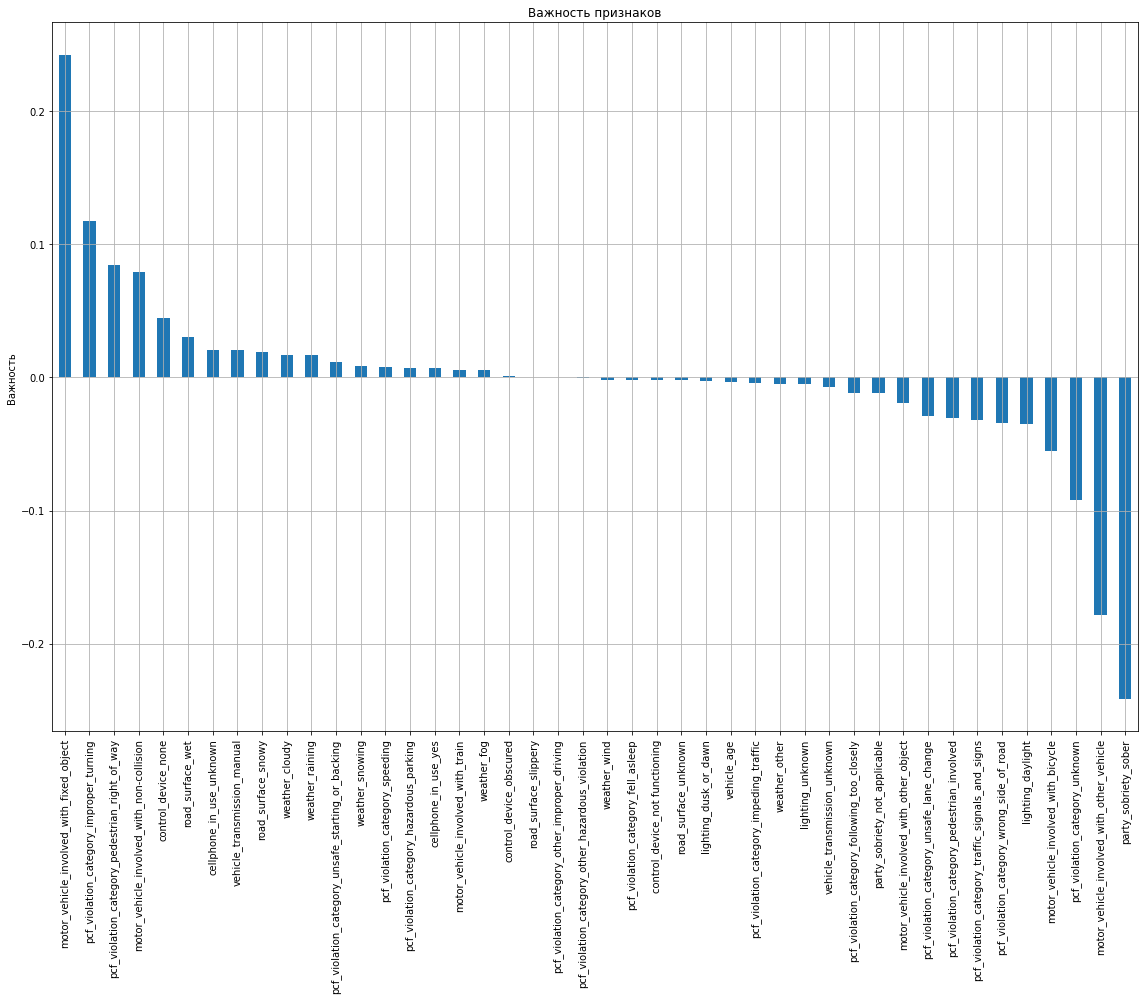

In [48]:
fig, ax = plt.subplots(figsize=(16,14))
df_tmp.corr().iloc[1].sort_values(ascending=False).drop('at_fault',axis = 0).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
plt.xticks(rotation=90)
plt.grid()

fig.tight_layout()

Из графика видим, что прямое влияние на виновность в ДТП оказывает:
 - Столкновения с неподвижными объектами
 - Нарушение ПДД - неправильный поворот
 - Нарушение ПДД - наезд на пешехода на пешеходном переходе
 - Использование телефона
 - Отсутствие контрольного устр-ва
 - Мокрая дорога
 - Автомобили с МКПП
 
Обратная зависимость:
 - Трезвый водитель
 - При дневном свете
 - По вине пешеходов

### Разделение на выборки и кодирование признаков

In [49]:
# Выделяем признаки и целевой признак:
features = df_dtp.drop('at_fault', axis=1)
target = df_dtp['at_fault']

In [50]:
# Разбиваем данные на выборки: обучающую и тестовую - в соотношении 75/25:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    train_size=0.75, 
                                                    random_state=SEED, 
                                                    shuffle=True,
                                                    stratify=df_dtp['at_fault']) # сохраняем баланс классов

In [51]:
# Смотрим размеры выборок на кодированных данных:
for i in [x_train, x_test, y_train, y_test]:
    print(i.shape)

(76797, 10)
(25600, 10)
(76797,)
(25600,)


Посмотрим на баланс классов:

1    0.531193
0    0.468807
Name: at_fault, dtype: float64


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

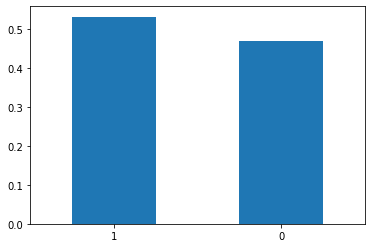

In [52]:
class_frequency = y_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)

Классы можно считать сбалансированными, распределние близко к 50%

In [53]:
cb_train = x_train.copy()
cb_test = x_test.copy()

In [54]:
tmp_train = x_train[cat_cols]
tmp_test= x_test[cat_cols]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(x_train[cat_cols])

tmp_train = pd.DataFrame(encoder_ohe.transform(x_train[cat_cols]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=x_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(x_test[cat_cols]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=x_test.index)

x_train.drop(cat_cols, axis=1, inplace=True)
x_train = x_train.join(tmp_train)

x_test.drop(cat_cols, axis=1, inplace=True)
x_test = x_test.join(tmp_test)

In [55]:
for i in [x_train, x_test, y_train, y_test]:
    print(i.shape)

(76797, 53)
(25600, 53)
(76797,)
(25600,)


In [56]:
# Выведем 5 случайных строк:
x_train.head()

,vehicle_age,weather_clear,weather_cloudy,weather_fog,weather_other,weather_raining,weather_snowing,weather_wind,pcf_violation_category_equipment_fault,pcf_violation_category_fell_asleep,...,lighting_unknown,vehicle_transmission_auto,vehicle_transmission_manual,vehicle_transmission_unknown,cellphone_in_use_no,cellphone_in_use_unknown,cellphone_in_use_yes,party_sobriety_drunk,party_sobriety_not_applicable,party_sobriety_sober
1236,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
81911,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
62217,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
38667,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
66774,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


***При сравнении моделей в качестве определяющей метрики будем использовать `precision`, т.к. она показывает долю истинно-положительных ответов.***

In [57]:
# Функция для вычисления метрик и построения графика:
def metrics_func(model):
    model.fit(x_train, y_train)
    predicted_test = model.predict(x_test)
    probabilities_test = model.predict_proba(x_test)
    probabilities_one_test = probabilities_test[:, 1]
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    print('Точность:', precision)
    print('Полнота:', recall)
    print('Доля правильных ответов:', accuracy_score(y_test, predicted_test)) 
    print('F1-мера:', f1_score(y_test, predicted_test))
    print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_test), '\n')
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, predicted_test))

# строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return precision, predicted_test, probabilities_one_test, model

### Модель DecisionTree

In [58]:
params =  {'max_depth': range (1,15, 2),
           'min_samples_leaf': range (1,12),
           'min_samples_split': range (2,14,2)}
           
model = DecisionTreeClassifier(random_state=SEED)

grid = RandomizedSearchCV(model,param_distributions=params, scoring='precision', n_jobs=-1)

grid.fit(x_train, y_train)

print(grid.best_params_)

{'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 5}


Точность: 0.8683016966235512
Полнота: 0.38012943079864686
Доля правильных ответов: 0.6401171875
F1-мера: 0.5287709068589842
AUC-ROC: 0.6957470551005629 

Матрица ошибок:
[[11218   784]
 [ 8429  5169]]


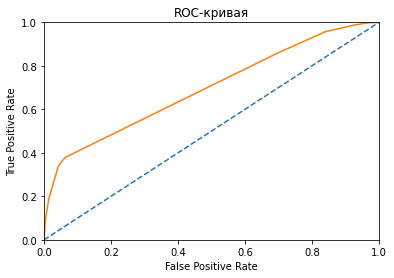

In [59]:
precision_dt, predictions_dt, probabilities_dt, model_dt  = metrics_func(DecisionTreeClassifier(max_depth=7, 
                                                                                                min_samples_split=12, 
                                                                                                min_samples_leaf=1,
                                                                                                class_weight='balanced',
                                                                                                random_state=SEED))

### Модель RandomForest

In [60]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
model = RandomForestClassifier(random_state=SEED)

grid = RandomizedSearchCV(model, param_distributions=params, scoring='precision', n_jobs=-1)

grid.fit(x_train, y_train)

print(grid.best_params_)

{'n_estimators': 145, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 12}


Точность: 0.8631527254869864
Полнота: 0.3877776143550522
Доля правильных ответов: 0.6421484375
F1-мера: 0.5351397980413051
AUC-ROC: 0.7004069577166858 

Матрица ошибок:
[[11166   836]
 [ 8325  5273]]


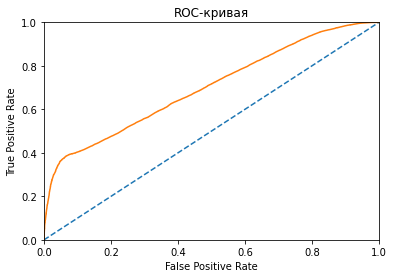

In [61]:
precision_rf, predictions_rf, probabilities_rf, model_rf = metrics_func(RandomForestClassifier(n_estimators=115,
                                                                                               max_depth=13, 
                                                                                               min_samples_split=6, 
                                                                                               min_samples_leaf=4,
                                                                                               class_weight='balanced',
                                                                                               random_state=SEED))

###  Модель LightGBM

In [62]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'num_leaves': range (2,50, 10)}
           
model = LGBMClassifier(random_state=SEED)

grid = RandomizedSearchCV(model, param_distributions=params, scoring='precision', n_jobs=-1)

grid.fit(x_train, y_train)

print(grid.best_params_)

{'num_leaves': 22, 'n_estimators': 55, 'max_depth': 12}


Точность: 0.8755088195386703
Полнота: 0.3796146492131196
Доля правильных ответов: 0.641796875
F1-мера: 0.5295988509284908
AUC-ROC: 0.7089404272450646 

Матрица ошибок:
[[11268   734]
 [ 8436  5162]]


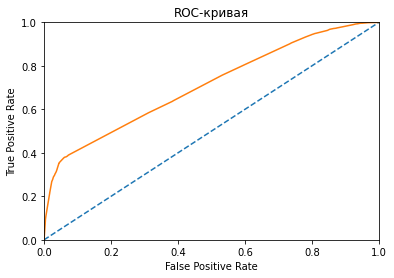

In [63]:
precision_lgbm, predictions_lgbm, probabilities_lgbm, model_lgbm = metrics_func(LGBMClassifier(boosting_type='gbdt', 
                                                                                               max_depth=9,
                                                                                               n_estimators=10,
                                                                                               learning_rate = 0.1,
                                                                                               num_leaves = 32,
                                                                                               class_weight='balanced',
                                                                                               random_state=SEED))

###  Модель CatBoost

In [64]:
def metrics_func2(model):
    model.fit(cb_train, y_train)
    predicted_test = model.predict(cb_test)
    probabilities_test = model.predict_proba(cb_test)
    probabilities_one_test = probabilities_test[:, 1]
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    print('Точность:', precision)
    print('Полнота:', recall)
    print('Доля правильных ответов:', accuracy_score(y_test, predicted_test)) 
    print('F1-мера:', f1_score(y_test, predicted_test))
    print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_test), '\n')
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, predicted_test))

# строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return precision, predicted_test, probabilities_one_test, model

In [65]:
model = CatBoostClassifier(cat_features= cat_cols,
                          random_seed=SEED)
parameters = {'iterations': range(100, 200), 'depth': range (1,10)}
    
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, n_iter = 10, scoring='precision', n_jobs=-1)
randm.fit(cb_train, y_train)

print(grid.best_params_)

Learning rate set to 0.402464
0:	learn: 0.6575278	total: 87.9ms	remaining: 10.9s
1:	learn: 0.6422253	total: 149ms	remaining: 9.15s
2:	learn: 0.6352853	total: 215ms	remaining: 8.73s
3:	learn: 0.6167119	total: 271ms	remaining: 8.19s
4:	learn: 0.6079277	total: 327ms	remaining: 7.85s
5:	learn: 0.6041317	total: 391ms	remaining: 7.76s
6:	learn: 0.6006179	total: 462ms	remaining: 7.79s
7:	learn: 0.5994170	total: 523ms	remaining: 7.64s
8:	learn: 0.5985902	total: 582ms	remaining: 7.5s
9:	learn: 0.5951099	total: 637ms	remaining: 7.33s
10:	learn: 0.5929099	total: 694ms	remaining: 7.19s
11:	learn: 0.5922135	total: 763ms	remaining: 7.19s
12:	learn: 0.5917433	total: 839ms	remaining: 7.23s
13:	learn: 0.5912653	total: 900ms	remaining: 7.14s
14:	learn: 0.5911746	total: 960ms	remaining: 7.04s
15:	learn: 0.5911141	total: 1.02s	remaining: 6.93s
16:	learn: 0.5910635	total: 1.08s	remaining: 6.84s
17:	learn: 0.5909208	total: 1.14s	remaining: 6.8s
18:	learn: 0.5908859	total: 1.19s	remaining: 6.64s
19:	learn: 0

Точность: 0.8526315789473684
Полнота: 0.39314605088983673
Доля правильных ответов: 0.6415625
F1-мера: 0.5381518018924905
AUC-ROC: 0.707446868871367 

Матрица ошибок:
[[11078   924]
 [ 8252  5346]]


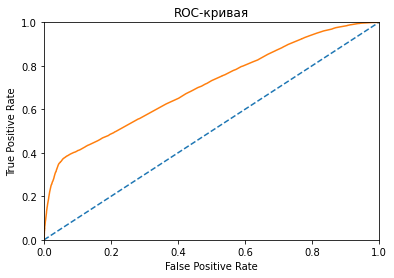

In [66]:
precision_cb, predictions_cb, probabilities_cb, model_cb = metrics_func2(CatBoostClassifier(cat_features= cat_cols,
                                                                                            depth=9,
                                                                                            learning_rate=0.5,
                                                                                            n_estimators=10, 
                                                                                            verbose=False,
                                                                                            random_seed=SEED))

### DummyClassifier

Точность: 0.531171875
Полнота: 1.0
Доля правильных ответов: 0.531171875
F1-мера: 0.6938109087198326
AUC-ROC: 0.5 

Матрица ошибок:
[[    0 12002]
 [    0 13598]]


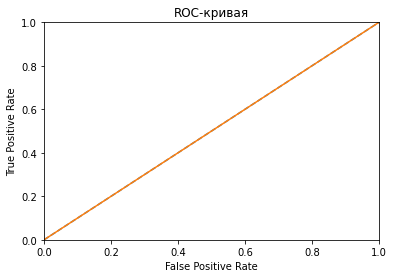

In [67]:
precision_dumm, predictions_dumm, probabilities_dumm, model_dumm  = metrics_func(DummyClassifier(strategy='most_frequent'))

### Вывод:

Оформим результат в виде таблицы:

In [68]:
result = pd.DataFrame ([[precision_dt],
                        [precision_rf],
                        [precision_lgbm],
                        [precision_cb],
                        [precision_dumm]], 
                       columns=['precision'],
                       index=['DecisionTree','RandomForest', 'LightGBM', 'CatBoost', 'Dummy'])
result.sort_values(by='precision', ascending=False)

,precision
LightGBM,0.875509
DecisionTree,0.868302
RandomForest,0.863153
CatBoost,0.852632
Dummy,0.531172


Все модели имеют примерно схожие показатели. 


Наибольшее значение точности имеет модель LightGBM - 0.875509. Модель адекватна и лучше константной.

## Проведите анализ важности факторов ДТП

### Анализ лучшей модели

Матрица ошибок для модели LightGBM:

In [69]:
confusion_matrix(y_test, predictions_lgbm)

array([[11268,   734],
       [ 8436,  5162]])

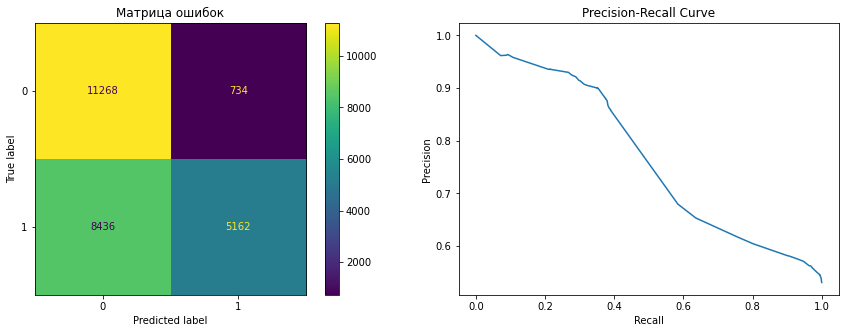

In [70]:
cm = confusion_matrix(y_test, predictions_lgbm)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot(ax=ax1)
ax1.set_title('Матрица ошибок')

precision, recall, thresholds = precision_recall_curve(y_test, probabilities_lgbm)
ax2.plot(recall, precision)
ax2.set_title('Precision-Recall Curve')
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
plt.show()

In [71]:
TN = cm[0][0]
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
total = cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 25600
Правильно классифицированные: 64.0%
Правильно классифицированная вина: 38.0%
Правильно классифицированое отсутствие вины: 94.0%
Прогнозируемая вина, соответствующая действительности: 88.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 57.0%


### Анализ важности факторов ДТП

Проанализируем важность основных факторов, влияющих на вероятность ДТП:

/opt/conda/lib/python3.9/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


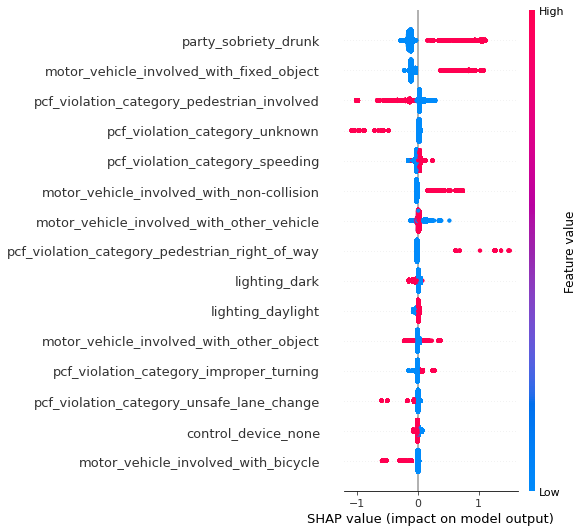

In [72]:
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train, show=False, max_display = 15)

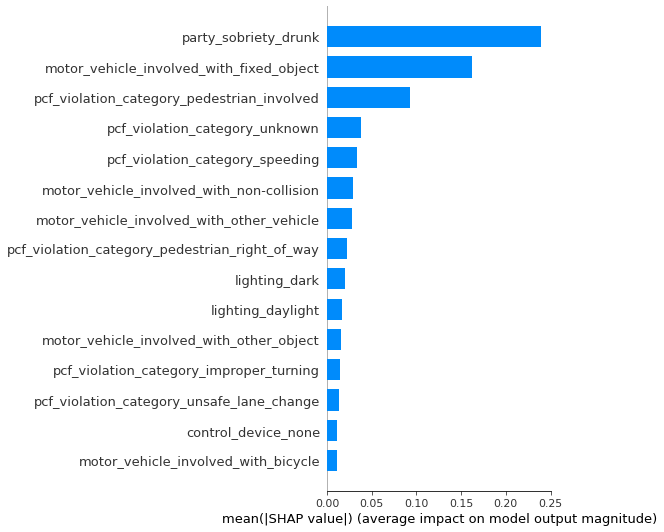

In [73]:
shap.summary_plot(shap_values, x_train, plot_type="bar", max_display = 15)

Наиболее важные факторы, влияющие на вероятность ДТП:
 - Факт алкогольного опьянения
 - Столкновение с неподвижным объектом
 - Наезд на пешехода (приемущество ТС)
 - Наезд на пешехода, когда пешеход имел приемущество
 - Неправильный поворот, разворот
 - Превышение скорости

Рассмотрим один из факторов (приемущество пешехода), и построим график зависимости фактора и целевой переменной:

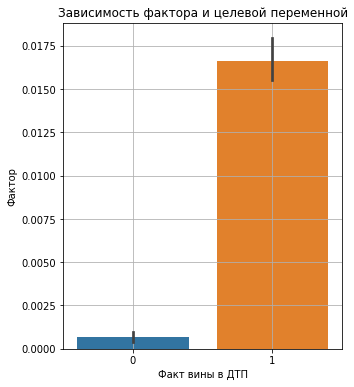

In [74]:
plt.figure(figsize=[5,6])
sns.barplot(x=y_train, y=x_train['pcf_violation_category_pedestrian_right_of_way'])
plt.title('Зависимость фактора и целевой переменной')
plt.xlabel('Факт вины в ДТП')
plt.ylabel('Фактор')
plt.grid()
plt.show()

 Для снижения случаев наезда на пешехода, автомобили предпочтительно оборудовать системой экстренного торможения. Многие марки автомобилей имеют такие системы - VW Front Assist, Volvo City Safety, Mercedes-Benz Active Brake Assist, Renault AEBS и т.д. 

Для снижения риска ДТП рекомендуется оборудование автомобилей:  
- встроенным навигатором, предупреждающем об ограничениях скорости и прокладывающим маршрут. Рекомедации по маршруту снизят риски нарушений.
- алкотестером и автоматической системой блокировки двигателя: Эти системы могут быть настроены на блокировку двигателя, если уровень опьянения водителя превышает определенный уровень.
- оборудовать автомобили системой пактроников. В большинстве случаев столкновене с неподвижным объектом происходит при парковке ТС. Данная система совместно с системой экстренного торможения существенно снизит вероятность ДТП.

## Выводы

В данной работе произведено исследование по созданию системы, которая могла бы оценить риск ДТП по совокупности факторов, для каршеринговой компании.

Исследована предоставленная sql-база, проведен статистический анализ некоторых факторов.

Выгрузили и подготовили данные для анализа за 2012 год. Опробовали ряд моделей классического машинного обучения и бустингов.

Испытанные модели показали результаты качественно лучше по сравнению с константной, что говорит о том что внедрение данных систем позволит улучшить вероятность распознать потенциального виновника ДТП по ряду признаков.

Наилучшая модель имеет следующие показатели:
 - Правильно классифицированные: 64.0%
 - Правильно классифицированная вина: 38.0%
 - Правильно классифицированое отсутствие вины: 94.0%
 - Прогнозируемая вина, соответствующая действительности: 88.0%
 - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 57.0%

Наиболее важные факторы, влияющие на вероятность ДТП, выявленные моделью:
 - Факт алкогольного опьянения
 - Столкновение с неподвижным объектом
 - Наезд на пешехода (приемущество ТС)
 - Наезд на пешехода, когда пешеход имел приемущество
 - Неправильный поворот, разворот
 - Превышение скорости


Для снижения риска ДТП рекомендуется оборудование автомобилей:  
- встроенным навигатором, предупреждающем об ограничениях скорости и прокладывающим маршрут. Рекомедации по маршруту снизят риски нарушений.
- алкотестером и автоматической системой блокировки двигателя: Эти системы могут быть настроены на блокировку двигателя, если уровень опьянения водителя превышает определенный уровень.
- оборудовать автомобили системой пактроников. В большинстве случаев столкновене с неподвижным объектом происходит при парковке ТС. Данная система совместно с системой экстренного торможения существенно снизит вероятность ДТП.



Создание системы оценки риска ДТП возможно, однако стоит учитывать не только уже собранные факторы, но и некоторые данные касающиеся самого водителя, такие как стаж вождения, участие в дтп в качестве виновника ранее и тд. 